In [20]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.atomic.features as fs
import socceraction.atomic.labels as lab

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
features_h5 = os.path.join(datafolder,"atomic-features.h5")
labels_h5 = os.path.join(datafolder,"atomic-labels.h5")
predictions_h5 = os.path.join(datafolder,"atomic-predictions.h5")

In [25]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "Premier League"]
traingames = games[games.season_name == "2017/2018"]
testgames = games[games.season_name == "2018/2019"]
print("nb of games:", len(traingames))

nb of games: 380


In [27]:
# 1. Select feature set X
xfns = [#fs.actiontype,
       fs.actiontype_onehot,
       #fs.bodypart,
       fs.bodypart_onehot,
       fs.goalscore,
       fs.location,
       fs.polar,
       fs.direction,
       fs.team,
       fs.time,
       fs.time_delta
      ]
nb_prev_actions = 2

Xcols = fs.feature_column_names(xfns,nb_prev_actions)

def getXY(games,Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id,desc="selecting features"):
        Xi = pd.read_hdf(features_h5,f"game_{game_id}")
        X.append(Xi[Xcols])
    X = pd.concat(X)

    # 2. Select label Y
    Ycols = ["scores","concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id,desc="selecting label"):
        Yi = pd.read_hdf(labels_h5,f"game_{game_id}")
        Y.append(Yi[Ycols])
    Y = pd.concat(Y)
    return X,Y

X,Y = getXY(traingames,Xcols)
print("X:", list(X.columns))
print("Y:", list(Y.columns))

selecting label: 100%|██████████| 380/380 [00:03<00:00, 95.61it/s]

X: ['type_pass_a0', 'type_cross_a0', 'type_throw_in_a0', 'type_freekick_crossed_a0', 'type_freekick_short_a0', 'type_corner_crossed_a0', 'type_corner_short_a0', 'type_take_on_a0', 'type_foul_a0', 'type_tackle_a0', 'type_interception_a0', 'type_shot_a0', 'type_shot_penalty_a0', 'type_shot_freekick_a0', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_keeper_pick_up_a0', 'type_clearance_a0', 'type_bad_touch_a0', 'type_non_action_a0', 'type_dribble_a0', 'type_goalkick_a0', 'type_receival_a0', 'type_out_a0', 'type_offside_a0', 'type_goal_a0', 'type_owngoal_a0', 'type_yellow_card_a0', 'type_red_card_a0', 'type_pass_a1', 'type_cross_a1', 'type_throw_in_a1', 'type_freekick_crossed_a1', 'type_freekick_short_a1', 'type_corner_crossed_a1', 'type_corner_short_a1', 'type_take_on_a1', 'type_foul_a1', 'type_tackle_a1', 'type_interception_a1', 'type_shot_a1', 'type_shot_penalty_a1', 'type_shot_freekick_a1', 'type_keeper_save_a1', 'type_keeper_claim_a1', 'type_keeper_punch_

In [28]:
%%time
# 3. train classifiers F(X) = Y
import xgboost

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    print(col)
    model = xgboost.XGBClassifier(n_jobs=-1)
    model.fit(X,Y[col])
    models[col] = model

scores
concedes
CPU times: user 7min 58s, sys: 3.17 s, total: 8min 1s
Wall time: 8min


In [29]:
from sklearn.metrics import brier_score_loss, roc_auc_score

#X,Y = getXY(traingames,Xcols)

X,Y = getXY(testgames,Xcols)

Y_hat = pd.DataFrame()
for col in Y.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(X)]
    print(f"Y: {col}")
    print(f"  Brier score: %.4f" % brier_score_loss(Y[col],Y_hat[col]))
    print(f"  ROC AUC: %.4f" % roc_auc_score(Y[col],Y_hat[col]))

selecting label: 100%|██████████| 380/380 [00:03<00:00, 97.88it/s] 


Y: scores
  Brier score: 0.0066
  ROC AUC: 0.8918
Y: concedes
  Brier score: 0.0009
  ROC AUC: 0.8804


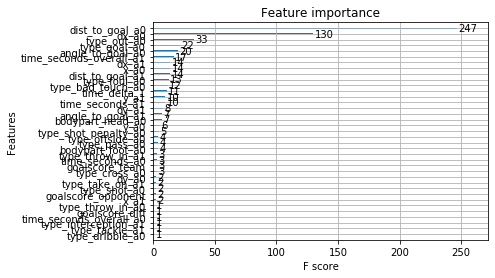

In [30]:
models["concedes"]
xgboost.plot_importance(models["scores"])

### Save predictions

In [31]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(testgames.game_id,"loading game ids"):
    Ai = pd.read_hdf(spadl_h5,f"atomic_actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A,Y_hat],axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions,desc="saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5,f"game_{int(k)}")

saving predictions per game: 100%|██████████| 380/380 [00:05<00:00, 69.93it/s]
